In [23]:
import torch
import torch.nn as nn
import moco.builder as builder
import moco.loader as loader
import torchvision.models as models
from PIL import Image
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

In [17]:
device =  torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [ ]:
class MoCo(nn.Module):
    """
    Build a MoCo model with: a query encoder, a key encoder, and a queue
    https://arxiv.org/abs/1911.05722
    """

    def __init__(self, base_encoder, dim=128, K=65536, m=0.999, T=0.07, mlp=False):
        """
        dim: feature dimension (default: 128)
        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)
        """
        super(MoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T

        # create the encoders
        # num_classes is the output fc dimension
        self.encoder_q = base_encoder(num_classes=dim)
        self.encoder_k = base_encoder(num_classes=dim)

        if mlp:  # hack: brute-force replacement
            dim_mlp = self.encoder_q.fc.weight.shape[1]
            self.encoder_q.fc = nn.Sequential(
                nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.encoder_q.fc
            )
            self.encoder_k.fc = nn.Sequential(
                nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.encoder_k.fc
            )

        for param_q, param_k in zip(
            self.encoder_q.parameters(), self.encoder_k.parameters()
        ):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """
        Momentum update of the key encoder
        """
        for param_q, param_k in zip(
            self.encoder_q.parameters(), self.encoder_k.parameters()
        ):
            param_k.data = param_k.data * self.m + param_q.data * (1.0 - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        # gather keys before updating queue
        # keys = concat_all_gather(keys)

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)
        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr : ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    def forward(self, im_q, im_k):
        """
        Input:
            im_q: a batch of query images
            im_k: a batch of key images
        Output:
            logits, targets
        """

        # compute query features
        q = self.encoder_q(im_q)  # queries: NxC
        q = nn.functional.normalize(q, dim=1)

        # compute key features
        with torch.no_grad():  # no gradient to keys
            self._momentum_update_key_encoder()  # update the key encoder

            # shuffle for making use of BN
            im_k, idx_unshuffle = self._batch_shuffle_ddp(im_k)

            k = self.encoder_k(im_k)  # keys: NxC
            k = nn.functional.normalize(k, dim=1)

            # undo shuffle
            k = self._batch_unshuffle_ddp(k, idx_unshuffle)

        # compute logits
        # Einstein sum is more intuitive
        # positive logits: Nx1
        l_pos = torch.einsum("nc,nc->n", [q, k]).unsqueeze(-1)
        # negative logits: NxK
        l_neg = torch.einsum("nc,ck->nk", [q, self.queue.clone().detach()])

        # logits: Nx(1+K)
        logits = torch.cat([l_pos, l_neg], dim=1)

        # apply temperature
        logits /= self.T

        # labels: positive key indicators
        labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()

        # dequeue and enqueue
        self._dequeue_and_enqueue(k)

        return logits, labels


## Main feature extraction

In [ ]:
# ! mkdir checkpoint
! wget https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_800ep/moco_v2_800ep_pretrain.pth.tar -P checkpoint
! wget https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v1_200ep/moco_v1_200ep_pretrain.pth.tar -P checkpoint

--2025-04-30 12:04:05--  https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_200ep/moco_v2_200ep_pretrain.pth.tar
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.239.111.120, 18.239.111.94, 18.239.111.129, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.239.111.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112133138 (107M) [application/octet-stream]
Saving to: ‘checkpoint/moco_v2_200ep_pretrain.pth.tar’

moco_v2_200ep_pretr 100%[===================>] 106.94M  12.4MB/s    in 21s     

2025-04-30 12:04:28 (4.98 MB/s) - ‘checkpoint/moco_v2_200ep_pretrain.pth.tar’ saved [112133138/112133138]



In [19]:
# model = builder.MoCo(
#     base_encoder=models.resnet50
# )
# model = MoCo(
#     base_encoder=models.__dict__['resnet50']
# )
model = models.__dict__['resnet50']()
model.fc = nn.Identity()
# for name, param in model.named_parameters():
#         if name not in ['fc.weight', 'fc.bias']:
#             param.requires_grad = False
# # init the fc layer
# model.fc.weight.data.normal_(mean=0.0, std=0.01)
# model.fc.bias.data.zero_()
chpkt = torch.load("/export/home/darpan/work_dir/cvProject/src/moco/checkpoint/moco_v2_800ep_pretrain.pth.tar")
# chpkt = torch.load("/export/home/darpan/work_dir/cvProject/src/moco/checkpoint/moco_v1_200ep_pretrain.pth.tar")
state_dict = chpkt['state_dict']
for k in list(state_dict.keys()):
    if k.startswith("module.encoder_q") and not k.startswith("module.encoder_q.fc"):
        # remove prefix
        state_dict[k[len("module.encoder_q.") :]] = state_dict[k]
    # delete renamed or unused k
    del state_dict[k]
msg = model.load_state_dict(state_dict, strict=False)
model = model.to(device)
model.eval()
print("Model loaded successfully.")
print(model)

/tmp/ipykernel_676641/1040010703.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chpkt = torch.load("/export/home/darpan/work_dir/cvProject/src/moco/checkpoint/moco_v2_

Model loaded successfully.
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kern

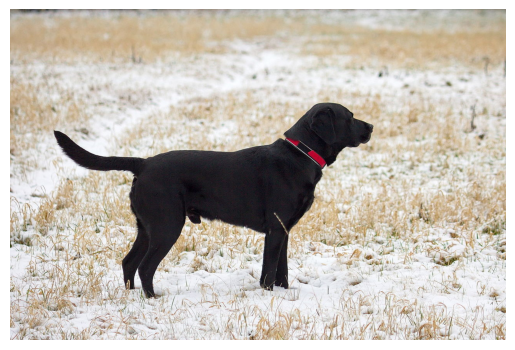

In [20]:
img_path = '/export/home/darpan/work_dir/cvProject/src/images/dog.jpg'
# load image


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dogImg = Image.open(img_path)
# cropt the image to 224x224
img = dogImg.resize((224, 224))

# plot the image
plt.imshow(dogImg)
plt.axis('off')
plt.show()

In [21]:
img = transform(dogImg)
img = img.unsqueeze(0)  # add batch dimension
img = img.to(device)

# get the features
with torch.no_grad():
    features = model(img)
    features = features.cpu().numpy()
    print(features.shape)

(1, 2048)


## Ignore below blocks

In [7]:
augmentation = [
    transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),
    transforms.RandomGrayscale(p=0.2),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]

In [25]:
loadImg = loader.TwoCropsTransform(
    transforms.Compose(augmentation)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.1062311].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.367669].


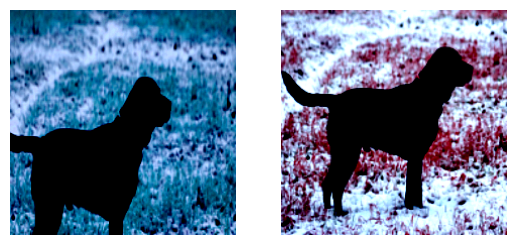

In [67]:
x, y = loadImg(img)

# plot the augmented images
plt.subplot(1, 2, 1)
plt.imshow(x.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()


In [44]:
x = x.unsqueeze(0).to(device)
y = y.unsqueeze(0).to(device)

# get the features
output, target = model(x, y)

ValueError: Default process group has not been initialized, please make sure to call init_process_group.